In [1]:
from datetime import datetime
import json
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from scipy.stats import t
import scipy.stats as sps
from scipy import stats

from keras import backend as kb
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

import backtesting
import helpers
import LSTM

## Produce LSTM models for alpha = 0.1, 0.05, 0.01, backtest it and save to dict.
### print out prediction grafs

/home/nikanor/.virtualenvs/pocket_trader/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/nikanor/.virtualenvs/pocket_trader/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


7/7 [==============================] - 0s 3ms/step - loss: 1.3692e-05

The mean squared error (MSE) on the test data set is 1.3692201719095465e-05 over 204 test samples.


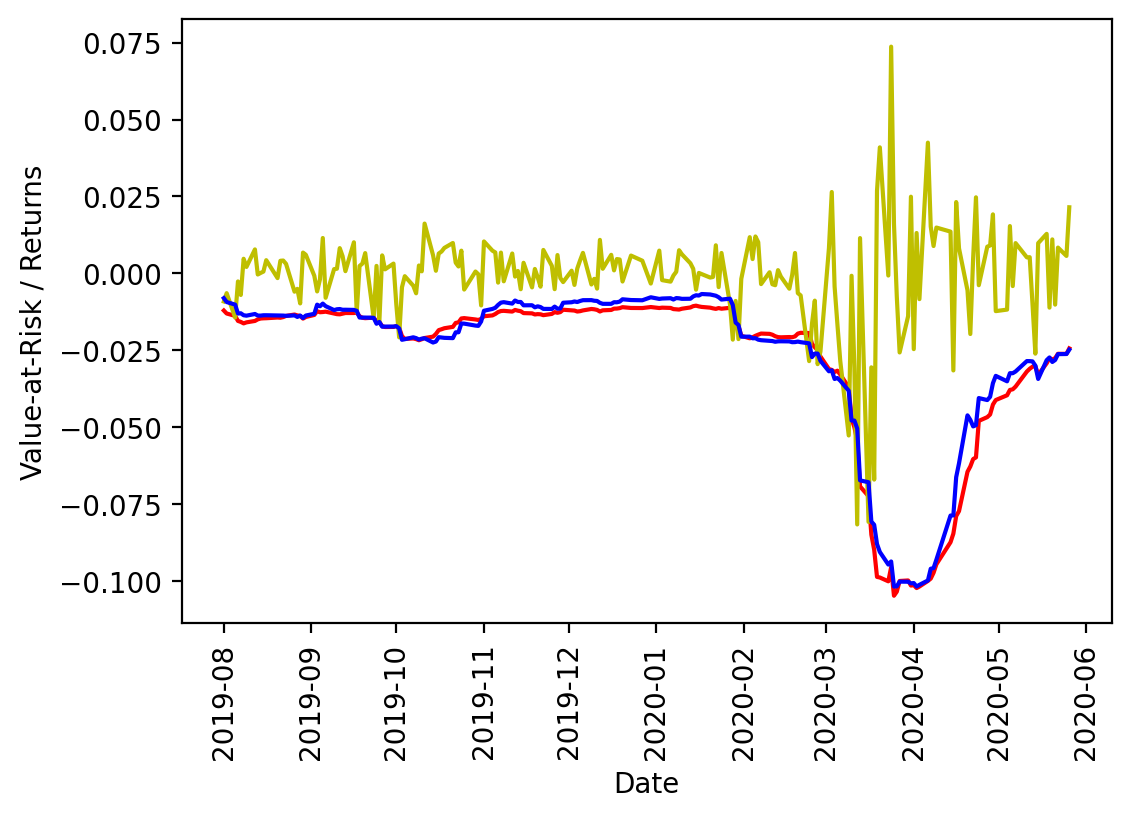

/home/nikanor/.virtualenvs/pocket_trader/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/nikanor/.virtualenvs/pocket_trader/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


7/7 [==============================] - 0s 12ms/step - loss: 5.0884e-05

The mean squared error (MSE) on the test data set is 5.088396210339852e-05 over 204 test samples.


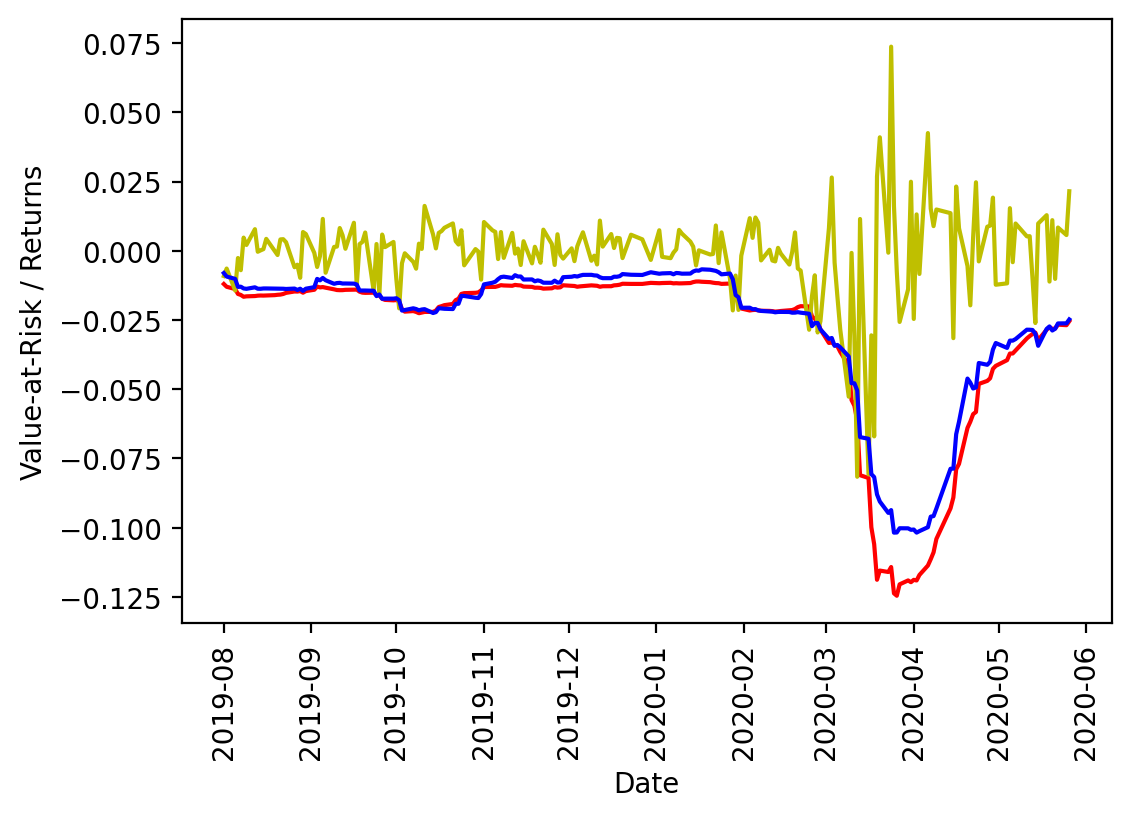

/home/nikanor/.virtualenvs/pocket_trader/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/nikanor/.virtualenvs/pocket_trader/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


7/7 [==============================] - 0s 11ms/step - loss: 1.0269e-04

The mean squared error (MSE) on the test data set is 0.00010269310587318614 over 204 test samples.


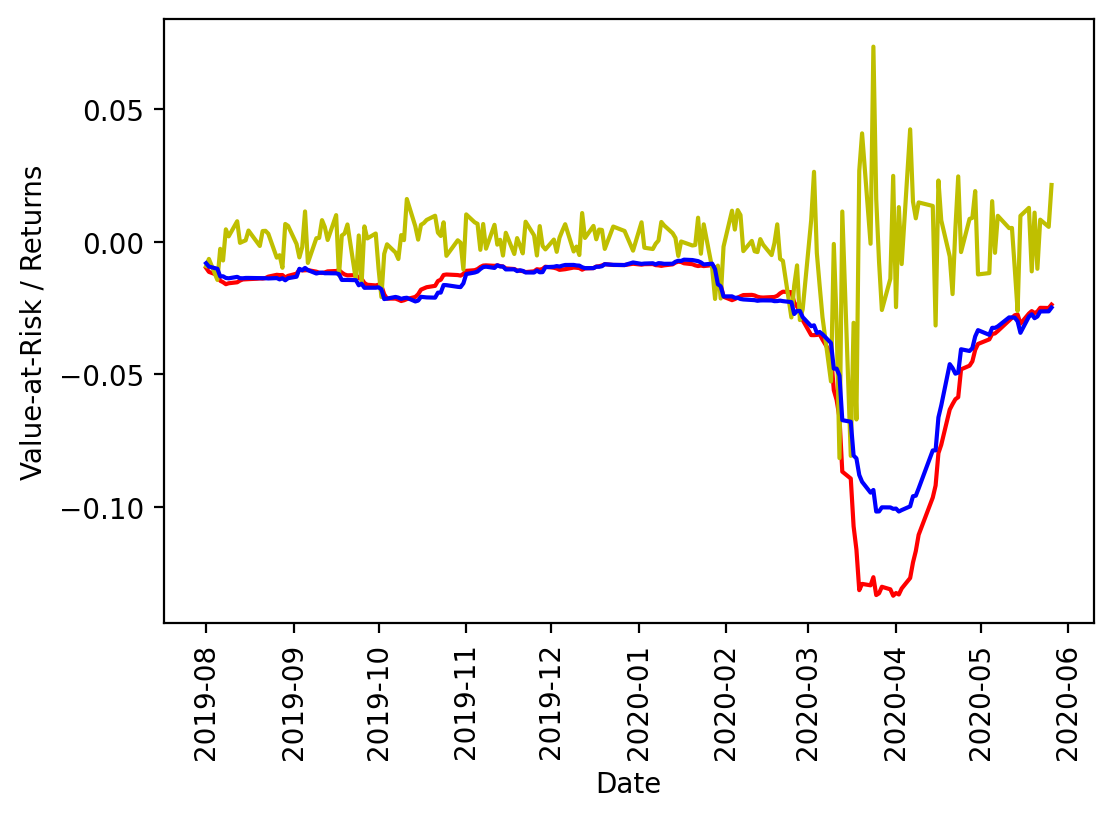

/home/nikanor/.virtualenvs/pocket_trader/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/nikanor/.virtualenvs/pocket_trader/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


7/7 [==============================] - 0s 11ms/step - loss: 6.3962e-05

The mean squared error (MSE) on the test data set is 6.396193930413574e-05 over 204 test samples.


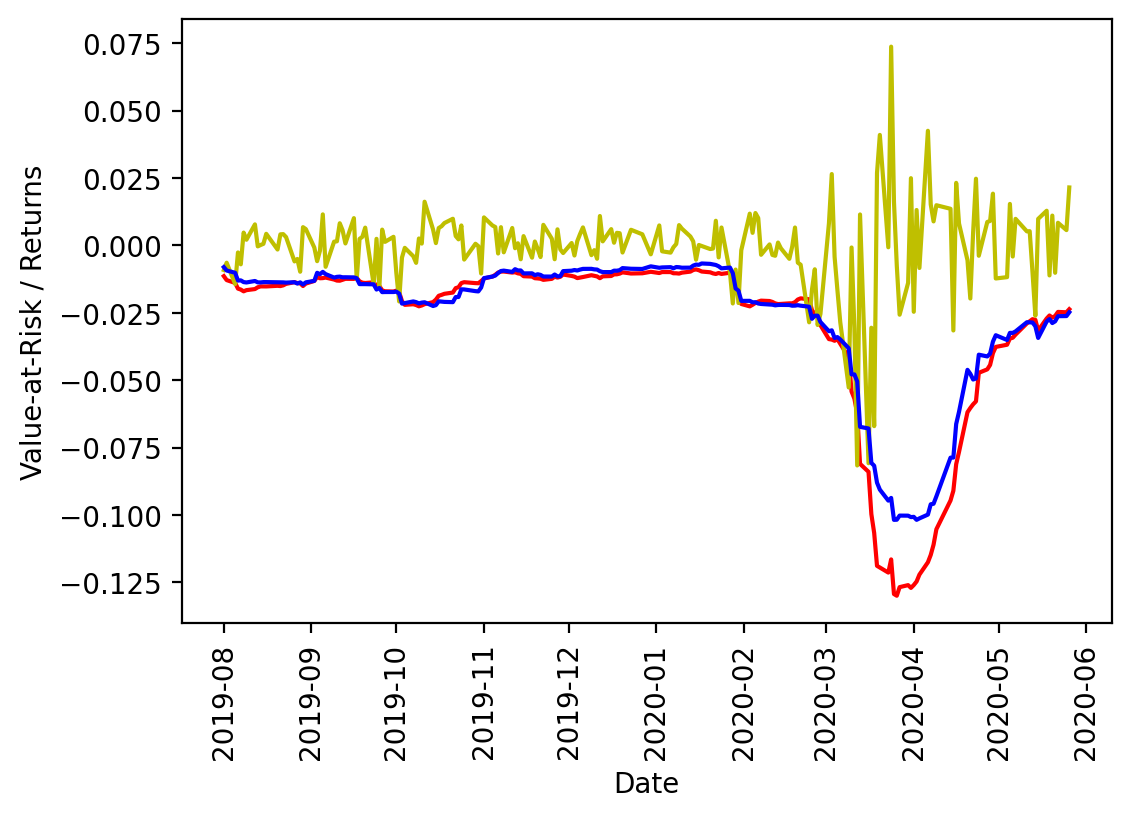

/home/nikanor/.virtualenvs/pocket_trader/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/nikanor/.virtualenvs/pocket_trader/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


7/7 [==============================] - 0s 10ms/step - loss: 8.7040e-05

The mean squared error (MSE) on the test data set is 8.704003994353116e-05 over 204 test samples.


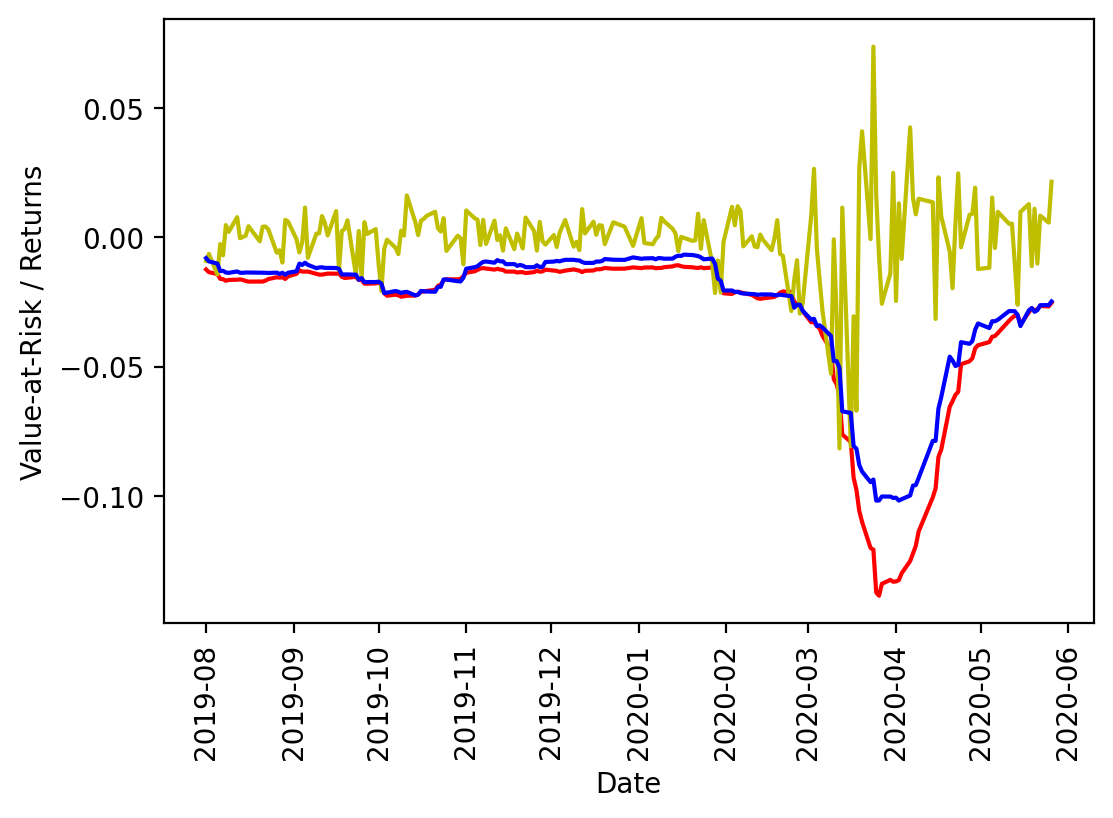

In [4]:
bt = {}
# for index in {'PX', 'WIG20', 'BUX', 'SAX'}:
for index in {'PX'}:
#     for alpha in {0.1, 0.05, 0.01}:
    for sequence_length in {10,20,40,60,100}:
        alpha = 0.05
        # random seed
        np.random.seed(111)

        # load the data
        path_to_dataset = f'{index}.csv'
        data = pd.read_csv(path_to_dataset, index_col = 'Date')
        data.index = pd.to_datetime(data.index)
        data.sort_values(by = ['Date'], inplace=True, ascending=True)

        #obtaining log returns
        data['log_return'] = np.log(1 + data['Close'].pct_change())
        data = data[1:]

        sequence_length = 20  # here we decide how far back we gonna take a look for prediction
        days_ahead = 1

        # Value at Risk based on realized data with t distribution assumption
        data['VaR'] = 0
        data['VaR'][1:] = helpers.historical_VaR(data['log_return'], 20, alpha)
        data = data[20:]

        # data['norm_return'] = (data['log_return'] - data['log_return'].mean()) / data['log_return'].std()
        data['norm_return'] = helpers.normalization(data['log_return'])

        x_train, y_train, x_test, y_test = helpers.data_preprocessing(
            returns = data['norm_return'],
            value_at_risk = data['VaR'],
            sequence_length = sequence_length,
            days_in_advance = days_ahead,
            split = 0.9
        )

        var_lstm_model = LSTM.lstm_for_var()

        # train the model
        var_lstm_model.fit(x_train, y_train, batch_size=512, epochs=50, validation_split=0.15, verbose=0)

        # evaluate the result
        test_mse = var_lstm_model.evaluate(x_test, y_test, verbose=1)
        print(f'\nThe mean squared error (MSE) on the test data set is {test_mse} over {len(y_test)} test samples.')

        predicted_values = var_lstm_model.predict(x_test)
        num_test_samples = len(predicted_values)
        predicted_values = np.reshape(predicted_values, (num_test_samples,))
        y_pred = pd.DataFrame(predicted_values, index = data[-num_test_samples:].index)

        # plot the results
        fig = plt.figure(dpi = 200)
        # plt.plot(y_test, 'b')
        plt.plot(y_pred, 'r')
        # plt.plot(predicted_values)
        plt.plot(data['log_return'][-len(y_pred):], 'y')
        plt.plot(data['VaR'][-len(y_pred):], 'b')
        # plt.plot((y_test + shifted_value)*(maximum-minimum) + minimum)
        # plt.plot((predicted_values + shifted_value)*(maximum-minimum) + minimum)

        plt.xlabel('Date')
        plt.ylabel('Value-at-Risk / Returns')
        # plt.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y-%m"))
        # plt.xaxis.set_minor_formatter(matplotlib.dates.DateFormatter("%Y-%m"))
        _=plt.xticks(rotation=90)  
        plt.show()
#         fig.savefig(f'prediction_plot_{index}_{alpha}.png', bbox_inches='tight')

        real = data['log_return'][-len(y_pred):]
        pred = predicted_values
        backtests = backtesting.BackTest(
            actual = data['log_return'][-len(y_pred):],
            forecast = predicted_values,
            alpha = alpha
        )
        bt[index + '_' + str(alpha)] = backtests.back_test()
        

In [15]:
var_lstm_model.history.model.history.history.keys()

dict_keys([])

### writing back-testing data to file

In [ ]:
with open('backtesting_results.json', 'w') as outfile:
    json.dump(bt, outfile)
